In [3]:
#Needed in general
# from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py as h5
import gc

#Quick fudge to make import from ../Scripts work
sys.path.append('../../Scripts')

#Custom imports
import ClassCOMPAS     as CC ###
# import ClassFormationChannels as FC a


# import script that has formation channel classification functions:
from PostProcessingScripts import * 
# from ClassFormationChannels_5mainchannels import * 



from astropy import units as u
from astropy import constants as const

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
print(fs)

import astropy
import seaborn as sns
from seaborn_utility import cmap_from_colour

24


# with LVK posteriors of GWs 

## prep code: 

In [4]:




def get_GW_posteriors(GW_list=['GW190408_181802']):
    
    """ This function retrieves the wanted posterior samples from the GWTC-2 database. 
    You will have to download these h5 files from https://www.gw-openscience.org/ 
    in my case the GW200115 and GW200105 files are located in my directory: 
    /Volumes/Andromeda/GWTC-1_LVK_catalog/GWTC-2_sample_release/ """
    
    
    # the quantiles we want to obtain, here: the median & 90% credible interval
    # so we want quantiles 0.05, 0.5 and 0.95
    y_quantiles  =  [0.05,   0.5,    0.95]   
    indexnames   = ['unit',  '0.05',  '0.5',  '0.95']
    
    # prepare DataFrame 
    xvarHeaders = ['Mass1', 'Mass2', \
                    'TotMass', 'ChirpMass', 'q', 'spin1', 'spin2', 'final_spin', 'final_mass_source' ]

    xvarUnits = ['Msun', 'Msun', 'Msun', 'Msun', '#', '#', '#', '#', 'Msun']
    
    # ALL GWTC per catalog 
    GWTC1_BNS = ['GW170817']
    GWTC1 = ['GW150914', 'GW151012', 'GW151226', 'GW170104', 'GW170608', 'GW170729',  'GW170809', 'GW170814', 'GW170817',  'GW170818', 'GW170823']
    GWTC2 = ['GW190408_181802','GW190412','GW190413_052954','GW190413_134308','GW190421_213856',\
    'GW190424_180648','GW190503_185404','GW190512_180714',\
    'GW190513_205428','GW190514_065416','GW190517_055101','GW190519_153544','GW190521_074359',\
    'GW190521','GW190527_092055','GW190602_175927','GW190620_030421','GW190630_185205','GW190701_203306',\
    'GW190706_222641','GW190707_093326','GW190708_232457','GW190720_000836',\
    'GW190727_060333','GW190728_064510','GW190731_140936','GW190803_022701','GW190828_063405',\
    'GW190828_065509','GW190910_112807','GW190915_235702','GW190924_021846','GW190929_012149',\
     'GW190930_133541', 'GW190425', 'GW190814', 'GW190426_152155']
    # O3b
    GWTC2b = ['GW200105_162426', 'GW200115_042309']
    
    
    
    
    for GW in GW_list:
        GW_ = str(GW)
        if GW in GWTC1:
            print(GW_)
            GW_file = '/Volumes/Andromeda/GWTC-1_LVK_catalog/GWTC-1_sample_release/'+GW_+'_GWTC-1.hdf5'
            GW = h5.File(GW_file, 'r')
            # GW170817 does not have an overall posterior, but insteaad low & high spin. we choose low spin. 
            if GW_ in GWTC1_BNS:
                detM1 = GW['IMRPhenomPv2NRT_lowSpin_posterior']['m1_detector_frame_Msun']
                detM2 = GW['IMRPhenomPv2NRT_lowSpin_posterior']['m2_detector_frame_Msun']
                LDistance = GW['IMRPhenomPv2NRT_lowSpin_posterior']['luminosity_distance_Mpc']
                spin1 = GW['IMRPhenomPv2NRT_lowSpin_posterior']['spin1']
                spin2 = GW['IMRPhenomPv2NRT_lowSpin_posterior']['spin2']
                costilt1 = GW['IMRPhenomPv2NRT_lowSpin_posterior']['costilt1']
                costilt2 = GW['IMRPhenomPv2NRT_lowSpin_posterior']['costilt2']

                spin1 = spin1 * costilt1
                spin2 = spin2 * costilt2
                del costilt1
                del costilt2
                
                final_spin = GW['IMRPhenomPv2NRT_lowSpin_posterior']['final_spin']
                final_mass_source = GW['IMRPhenomPv2NRT_lowSpin_posterior']['final_mass_source']
                
                
                
            else:
                detM1 = GW['Overall_posterior']['m1_detector_frame_Msun']
                detM2 = GW['Overall_posterior']['m2_detector_frame_Msun']
                LDistance = GW['Overall_posterior']['luminosity_distance_Mpc']
                spin1 = GW['Overall_posterior']['spin1']
                spin2 = GW['Overall_posterior']['spin2']
                costilt1 = GW['Overall_posterior']['costilt1']
                costilt2 = GW['Overall_posterior']['costilt2']

                spin1 = spin1 * costilt1
                spin2 = spin2 * costilt2
                del costilt1
                del costilt2
                final_spin = GW['Overall_posterior']['final_spin']
                final_mass_source = GW['Overall_posterior']['final_mass_source']
            z_ = _redshift(LDistance)
            # convert to source frame masses
            M1 = detM1 / (1+z_)
            M2 = detM2 / (1+z_)
            
            mass_1_source = M1 
            mass_2_source = M2
            total_mass_source = M1+M2
            chirp_mass_source = chirpmass(M1, M2)
            mass_ratio= M1 / M2
            


        
        
        elif GW in GWTC2:

            print(GW_)
            GW_file = '/Volumes/Andromeda/GWTC-1_LVK_catalog/GWTC-2_sample_release/' + GW_ +'_comoving.h5'
            GW = h5.File(GW_file, 'r')

            data = read(GW_file)
            samples_dict = data.samples_dict
            posterior_samples = samples_dict['PublicationSamples']
#             parameters = sorted(list(posterior_samples.keys()))

            mass_1_source = posterior_samples['mass_1_source']
            mass_2_source = posterior_samples['mass_2_source']
            total_mass_source = posterior_samples['total_mass_source']
            chirp_mass_source= posterior_samples['chirp_mass_source']
            spin1 = posterior_samples['spin_1z']
            spin2 = posterior_samples['spin_2z']
            # our mass ratio is defined the other way around
            mass_ratio = mass_1_source / mass_2_source  # is the same as: posterior_samples['inverted_mass_ratio']
            

            final_spin = posterior_samples['final_spin']
            final_mass_source = posterior_samples['final_mass_source']            

    
        
        
        elif GW_ in GWTC2b:
            print(GW_)
            GW_file = '/Volumes/Andromeda/GWTC-1_LVK_catalog/GWTC-2_sample_release/' + GW_ +'_posterior_samples_v2.h5'
            GW = h5.File(GW_file, 'r')
            print(GW['C01:Combined_PHM_high_spin']['posterior_samples']['mass_1_source'][...].squeeze())

            posterior_samples = GW['C01:Combined_PHM_high_spin']['posterior_samples']
            mass_1_source     = posterior_samples['mass_1_source'][...].squeeze()
            mass_2_source     = posterior_samples['mass_2_source'][...].squeeze()
            total_mass_source = posterior_samples['total_mass_source'][...].squeeze()
            chirp_mass_source = posterior_samples['chirp_mass_source'][...].squeeze()
            spin1             = posterior_samples['spin_1z'][...].squeeze()
            spin2             = posterior_samples['spin_2z'][...].squeeze()
            # mass ratio
            mass_ratio = mass_2_source / mass_1_source  # is the same as: posterior_samples['inverted_mass_ratio']


            final_spin = posterior_samples['final_spin']
            final_mass_source = posterior_samples['final_mass_source']            





    # obtain BH and NS masses from combining GW posteriors.
    # by definition LIGO gives Most massive and least massive. 
    xvarlist = [mass_1_source, mass_2_source, total_mass_source, chirp_mass_source, mass_ratio, spin1, spin2]





    print('completed!')
                  
        
        
    return xvarlist
  

In [5]:
xvars_GW200105 = get_GW_posteriors(GW_list=['GW200105_162426'])
xvars_GW200115 = get_GW_posteriors(GW_list=['GW200115_042309'])

GW200105_162426
[8.37598737 8.73262229 8.41748688 ... 8.98889051 9.25655911 9.00633161]
completed!
GW200115_042309
[4.63391569 5.73221847 6.27705374 ... 4.87480358 6.58584113 7.62977064]
completed!


In [7]:
fs=20
def plotHist_OtherModels(axe, BPSlist=['I', 'J', 'P', 'Q'], SFRDlist=[], jj_minn=0, jj_maxx=10):
    

    nn=18
    COLORS = [sns.color_palette("husl", nn)[0], sns.color_palette("husl", nn)[4], sns.color_palette("husl", nn)[9], sns.color_palette("husl", nn)[14]]
    
    
    
    for ind_bps, BPSmodelName in enumerate(BPSlist):
        
        

            
        
        
        print(BPSmodelName)
        DCOtype='BHNS'
        # path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)
    
    
        # M1 will be the most massive, M2 the least massive compact object. 
        M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
        Chirpmass = chirpmass(M1, M2)
        MassRatio = M2/M1
        
    
    
        for ind_sfrd, mssfr in enumerate(SFRDlist): 
            
            
            if (BPSmodelName==['I']) & (mssfr=='213'):
                print('skipping')
            elif (BPSmodelName==['J']) & (mssfr in ['113', '212', '213', '323', '333']):
                print('skipping')
            elif (BPSmodelName==['P']) & (mssfr in ['112', '212']):
                print('skipping')
            elif (BPSmodelName==['Q']) & (mssfr in ['112', '113', '312', '332']):
                print('skipping')                
            # in all other cases plot gray CDF lines   
            else: 
            
                ### read in MSSFR weights: ###
    #             print('mssfr = %s'%mssfr)
                # get detected weights
                fparam_key = 'weights_detected'
                weightheader = 'w_' + mssfr
                w = fdata[fparam_key][weightheader][...].squeeze()

                labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{BH}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{NS}} \ [\rm{M}_{\odot}]$',\
                       r'$q $'] #,  r'$\log_{10}(t) $']              
                varlist = [Chirpmass, M1, M2, MassRatio]



                maskGW200105  = ((M1 <= (8.9+1.2))  & (M1>=(8.9-1.5))) & ((M2 <= (1.9+0.3))  & (M2>=(1.9-0.2))) & ((chirpmass(M1,M2)>=(3.41-0.07)) & (chirpmass(M1,M2)<=(3.41+0.08))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35))) & (((M2+M1)>=(10.9-1.2)) & ((M2+M1)<=(10.9+1.1)))
                maskGW200115  = ((M1 <= (5.7+1.8))  & (M1>=(5.7-2.1))) & ((M2 <= (1.5+0.7))  & (M2>=(1.5-0.3))) & ((chirpmass(M1,M2)>=(2.42-0.07)) & (chirpmass(M1,M2)<=(2.42+0.05))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35))) & (((M2+M1)>=(7.1 -1.4)) & ((M2+M1)<=(7.1 +1.5)))



                fs_l = 20 # label fontsize

                cGW1 = 'lightskyblue' 
                cGW0 = 'orange'
                LEGEND = True 



                jj=0

                axe.hist(varlist[jj], bins=len(varlist[jj]), weights=w, cumulative=True, density=True, color='lightgray', histtype='step', lw=3, zorder=6)





    return

In [8]:
fs=20
def plotHist_MatchingModels(axe, BPSlist=['I', 'J', 'P', 'Q'], SFRDlist=[], jj_minn=0, jj_maxx=10):
    

    nn=18
    COLORS = [sns.color_palette("husl", nn)[0], sns.color_palette("husl", nn)[4], sns.color_palette("husl", nn)[9], sns.color_palette("husl", nn)[14]]
    
    
    
    for ind_bps, BPSmodelName in enumerate(BPSlist):
        print(BPSmodelName)
        DCOtype='BHNS'
        # path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)
    
    
        # M1 will be the most massive, M2 the least massive compact object. 
        M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
        Chirpmass = chirpmass(M1, M2)
        MassRatio = M2/M1
        
    
    
        for ind_sfrd, mssfr in enumerate(SFRDlist[ind_bps]): 
            ### read in MSSFR weights: ###
#             print('mssfr = %s'%mssfr)
            # get detected weights
            fparam_key = 'weights_detected'
            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()

            labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{BH}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{NS}} \ [\rm{M}_{\odot}]$',\
                   r'$q $'] #,  r'$\log_{10}(t) $']              
            varlist = [Chirpmass, M1, M2, MassRatio]



            maskGW200105  = ((M1 <= (8.9+1.2))  & (M1>=(8.9-1.5))) & ((M2 <= (1.9+0.3))  & (M2>=(1.9-0.2))) & ((chirpmass(M1,M2)>=(3.41-0.07)) & (chirpmass(M1,M2)<=(3.41+0.08))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35))) & (((M2+M1)>=(10.9-1.2)) & ((M2+M1)<=(10.9+1.1)))
            maskGW200115  = ((M1 <= (5.7+1.8))  & (M1>=(5.7-2.1))) & ((M2 <= (1.5+0.7))  & (M2>=(1.5-0.3))) & ((chirpmass(M1,M2)>=(2.42-0.07)) & (chirpmass(M1,M2)<=(2.42+0.05))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35))) & (((M2+M1)>=(7.1 -1.4)) & ((M2+M1)<=(7.1 +1.5)))

            

#             # GW lists:
#             print('obtaining GW200105 and GW200115 posteriors')
#             mass_1_source_GW200105, mass_2_source_GW200105, _, chirp_mass_source_GW200105, mass_ratio_GW200105, _, _ = get_GW_posteriors(GW_list=['GW200105_162426'])
#             mass_1_source_GW200115, mass_2_source_GW200115, _, chirp_mass_source_GW200115, mass_ratio_GW200115, _, _ = get_GW_posteriors(GW_list=['GW200115_042309'])

#             varlist_GW200115 = [chirp_mass_source_GW200115, mass_1_source_GW200115, mass_2_source_GW200115, mass_ratio_GW200115]
#             varlist_GW200105 = [chirp_mass_source_GW200105, mass_1_source_GW200105, mass_2_source_GW200105, mass_ratio_GW200105]


            fs_l = 20 # label fontsize

            cGW1 = 'lightskyblue' 
            cGW0 = 'orange'
            LEGEND = True 



            jj=0

            # PLOT HISTOGRAMS
#             nrbins=np.linspace(jj_minn, jj_maxx, 75)
#             hist, bin_edges = np.histogram(varlist[jj], bins=nrbins, weights=w)
#             yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
#             xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
#             axe.plot(xx, yy, color=colorDirDict[BPSmodelName], lw=5, zorder=2, label=BPSmodelName)
            
            axe.hist(varlist[jj], bins=len(varlist[jj]), weights=w, cumulative=True, density=True, color=COLORS[ind_bps], histtype='step', lw=5, zorder=20)
            
            
            
            
            mask_GWlike =   ((chirpmass(M1,M2)>=(2.42-0.07)) & (chirpmass(M1,M2)<=(3.41+0.08)))
#             print('fraction GW-like [chirpmass]=', np.sum(w[mask_GWlike]) / np.sum(w))
            mask_GWlike =   ((chirpmass(M1,M2)>=0.75*(2.42-0.07)) & (chirpmass(M1,M2)<=1.25*(3.41+0.08)))
#             print('fraction GW-like, broader [chirpmass]=', np.sum(w[mask_GWlike]) / np.sum(w))
            

            
            
            

    #### LVK sources ###
    nrbins = 50 

#             hist, bin_edges = np.histogram( varlist_GW200105[jj], bins=nrbins)
#             yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
#             xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
#             axe.plot(xx, yy, color=cGW0, lw=3, zorder=5)   


    xx = np.linspace(0,1E4, 100)

    # GW 200105
    axe.fill_betweenx(y=xx, x1=np.ones_like(xx)*(3.41-0.07), x2=np.ones_like(xx)*(3.41+0.08), color=cGW0, zorder=4, alpha=0.1)
    axe.plot(np.ones_like(xx)*3.41, xx, color=cGW0, zorder=5, alpha=1, lw=2)
    axe.annotate(r'GW200105', xy=((3.41-0.09), 0.98), xycoords="data", ha="right", va="top", \
                 color=cGW0, fontsize=30, fontname="Avenir", zorder=200) #, rotation=90)
   
    # GW200115
    axe.fill_betweenx(y=xx, x1=np.ones_like(xx)*(2.42-0.07), x2=np.ones_like(xx)*(2.42+0.05), color=cGW1, zorder=4, alpha=0.1)
    axe.plot(np.ones_like(xx)*2.42, xx,  color=cGW1, zorder=5, alpha=1, lw=2)
    
    axe.annotate(r'GW200115', xy=((2.42-0.09), 0.98), xycoords="data", ha="right", va="top", \
                 color=cGW1, fontsize=30, fontname="Avenir", zorder=200)#, rotation=90)
   
    
#     axe.annotate()

#             hist, bin_edges = np.histogram(varlist_GW200115[jj], bins=nrbins)
#             yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
#             xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
#             axe.plot(xx, yy, color=cGW1, lw=3, zorder=5)  
#             axe.fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW1, zorder=4, alpha=0.2)




    #######################




    # BEAUTIFY: 

    ylabel='PDF'

    axe.set_xlim(jj_minn, jj_maxx)
    axe.set_ylim(0,1)
    if labellist[jj]== r'$m_{\rm{BH}} \ [M_{\odot}]$':
        axe.set_xlim(jj_minn, 27)
    if labellist[jj]==  r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$':
        axe.set_xlim(1, 5.5)
    if labellist[jj]==  r'$m_{\rm{NS}} \ [M_{\odot}]$':
        axe.set_xlim(0.9, jj_maxx)                    

    if labellist[jj]==r'$q $':
        xx = [-100, -50]
        axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightgray', zorder=2, alpha=0.5, label='All BHNS')
        axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='orange', zorder=2, alpha=0.3, label = 'GW200105')
        axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
        ax.legend(fontsize=26, loc='upper center', bbox_to_anchor=(0.65, 0.9), frameon=False)


    ax == layoutAxes(ax, nameX=labellist[jj], nameY=r'$\textbf{PDF}$', setMinor=False, labelpad=10, fontsize=fs_l+10)

            
    
    
    Ilabel = ['I213']
    Jlabel = ['J113, J212, J213, J323, J333']
    Plabel = ['P112, P212']
    Qlabel = ['Q112, Q113, Q312, Q332']
    labels = [Ilabel, Jlabel, Plabel, Qlabel]
    
    for ind_bps, BPSmodelName in enumerate(BPSlist):
    
        plt.plot([-100,-80], [-100,-80], lw=5, color=COLORS[ind_bps], label=labels[ind_bps][0])
    
    ax.legend(fontsize=fs_l, loc='lower right')

                    
                    








# PLOT THE CDF chirpmass 

A
B
C
D
E
F
G
H
I
J
K
L
M
N
O
P
Q
R
S
T
I
J
P
Q


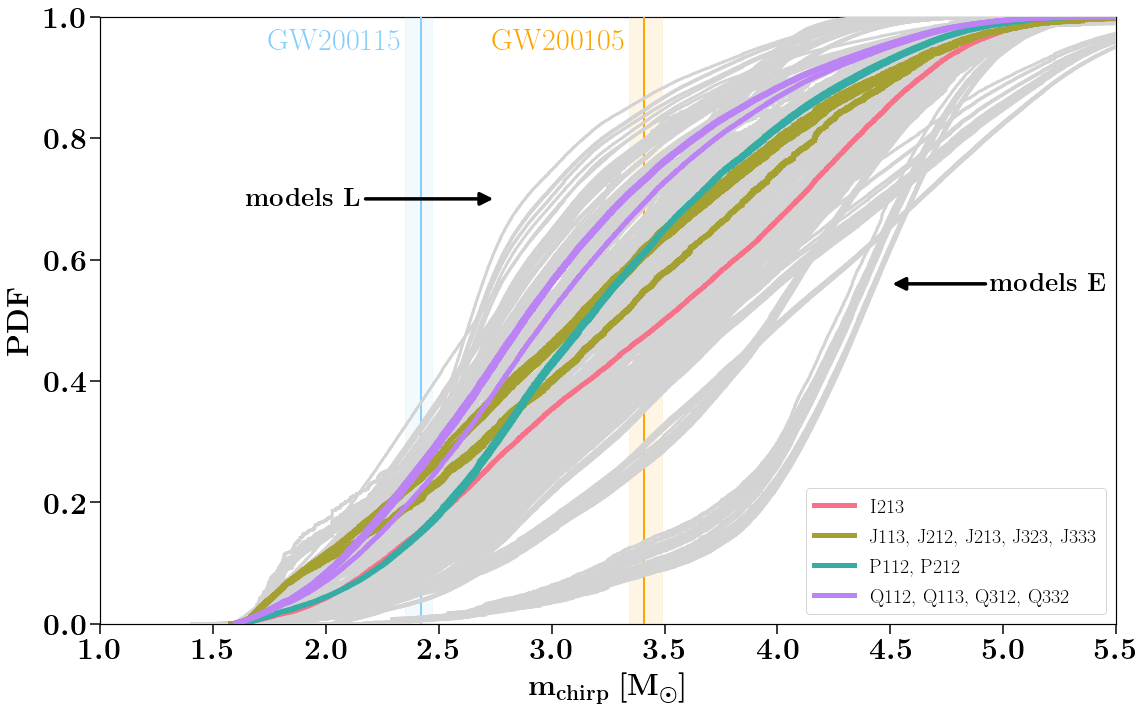

In [9]:
                    
labellist=[r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$m_{\rm{BH}} \ [M_{\odot}]$', r'$m_{\rm{NS}} \ [M_{\odot}]$',\
           r'$q $'] #,  r'$\log_{10}(t) $']     

f, ax= plt.subplots(ncols=1,nrows=1,figsize=(16,10))



plotHist_OtherModels(axe=ax, BPSlist=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T'], SFRDlist=MSSFRnameslist, jj_minn=1, jj_maxx=10)
plotHist_MatchingModels(axe=ax, BPSlist=['I', 'J', 'P', 'Q'], SFRDlist=[['213'],['113', '212', '213', '323', '333'],['112', '212'], ['112', '113', '312', '332']], jj_minn=1, jj_maxx=10)




# properties  arrow 
strr = r"\textbf{models E} "
x_xy, y_xy = 4.5, 0.56
x_xytext, y_xytext = 5.2, 0.56
conn = "arc3,rad=+0.0"

# draw arrow
ax.annotate(strr,
  xy=(x_xy, y_xy), xycoords='data',
  xytext=(x_xytext, y_xytext), textcoords='data',
  size=26, va="center", ha="center",
  arrowprops=dict(arrowstyle="-|>",
                  connectionstyle=conn,
                  fc="k", lw=3.5), zorder=200000)   


# properties  arrow 
strr = r"\textbf{models L } "
x_xy, y_xy = 2.75, 0.7
x_xytext, y_xytext = 1.9, 0.7
conn = "arc3,rad=+0.0"

# draw arrow
ax.annotate(strr,
  xy=(x_xy, y_xy), xycoords='data',
  xytext=(x_xytext, y_xytext), textcoords='data',
  size=26, va="center", ha="center",
  arrowprops=dict(arrowstyle="-|>",
                  connectionstyle=conn,
                  fc="k", lw=3.5), zorder=200000)  



plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./CDF_matching_models_Mchirp'  + '.png', transparent=False, bbox_inches="tight", dpi=600)
# plt.savefig('./CDF_matching_models_Mchirp'  + '.pdf', transparent=False, bbox_inches="tight")
plt.show()



# Just to test the arrows location

E
L


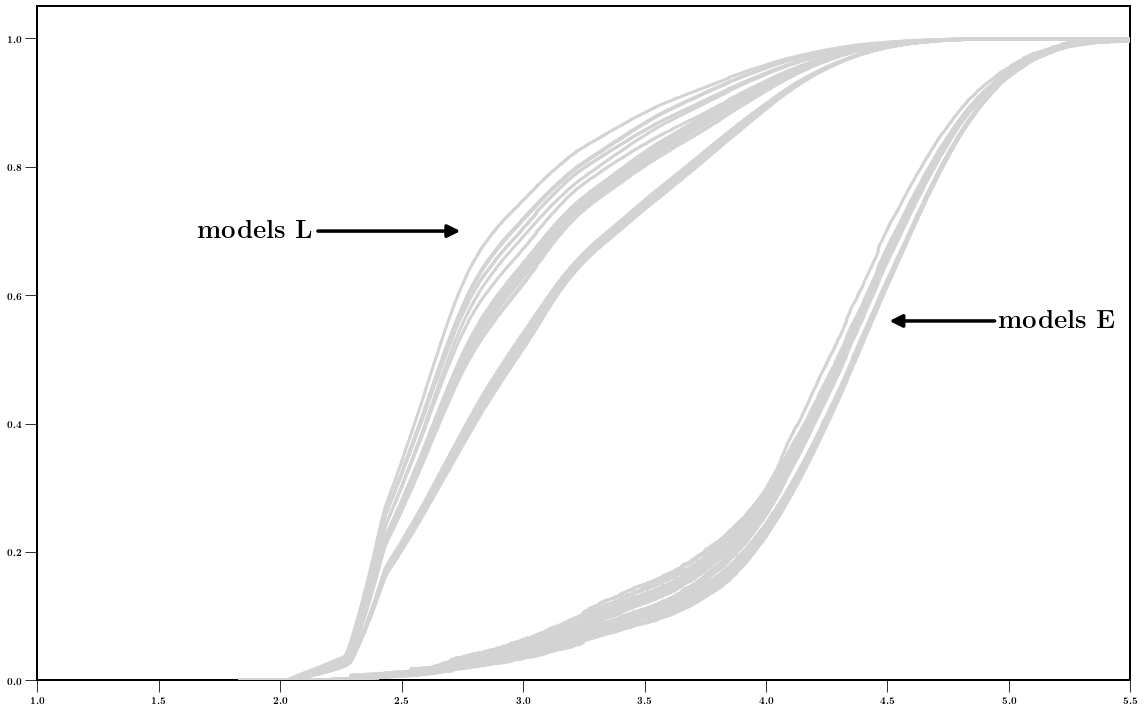

In [10]:
                    
labellist=[r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$m_{\rm{BH}} \ [M_{\odot}]$', r'$m_{\rm{NS}} \ [M_{\odot}]$',\
           r'$q $'] #,  r'$\log_{10}(t) $']     

f, ax= plt.subplots(ncols=1,nrows=1,figsize=(16,10))



plotHist_OtherModels(axe=ax, BPSlist=[ 'E', 'L'], SFRDlist=MSSFRnameslist, jj_minn=1, jj_maxx=10)
# plotHist_MatchingModels(axe=ax, BPSlist=['I', 'J', 'P', 'Q'], SFRDlist=[['213'],['113', '212', '213', '323', '333'],['112', '212'], ['112', '113', '312', '332']], jj_minn=1, jj_maxx=10)


# properties  arrow 
strr = r"\textbf{models E} "
x_xy, y_xy = 4.5, 0.56
x_xytext, y_xytext = 5.2, 0.56
conn = "arc3,rad=+0.0"

# draw arrow
ax.annotate(strr,
  xy=(x_xy, y_xy), xycoords='data',
  xytext=(x_xytext, y_xytext), textcoords='data',
  size=26, va="center", ha="center",
  arrowprops=dict(arrowstyle="-|>",
                  connectionstyle=conn,
                  fc="k", lw=3.5), zorder=200000)   



# properties  arrow 
strr = r"\textbf{models L } "
x_xy, y_xy = 2.75, 0.7
x_xytext, y_xytext = 1.9, 0.7
conn = "arc3,rad=+0.0"

# draw arrow
ax.annotate(strr,
  xy=(x_xy, y_xy), xycoords='data',
  xytext=(x_xytext, y_xytext), textcoords='data',
  size=26, va="center", ha="center",
  arrowprops=dict(arrowstyle="-|>",
                  connectionstyle=conn,
                  fc="k", lw=3.5), zorder=200000)  


ax.set_xlim(1, 5.5)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)


# plt.savefig('./CDF_matching_models_Mchirp'  + '.png', transparent=False, bbox_inches="tight")
plt.show()



# Plot the PDFs:

mssfr = 213
obtaining GW200105 and GW200115 posteriors
GW200105_162426
[8.37598737 8.73262229 8.41748688 ... 8.98889051 9.25655911 9.00633161]
completed!
GW200115_042309
[4.63391569 5.73221847 6.27705374 ... 4.87480358 6.58584113 7.62977064]
completed!
mssfr = 113
obtaining GW200105 and GW200115 posteriors
GW200105_162426
[8.37598737 8.73262229 8.41748688 ... 8.98889051 9.25655911 9.00633161]
completed!
GW200115_042309
[4.63391569 5.73221847 6.27705374 ... 4.87480358 6.58584113 7.62977064]
completed!
mssfr = 112
obtaining GW200105 and GW200115 posteriors
GW200105_162426
[8.37598737 8.73262229 8.41748688 ... 8.98889051 9.25655911 9.00633161]
completed!
GW200115_042309
[4.63391569 5.73221847 6.27705374 ... 4.87480358 6.58584113 7.62977064]
completed!
mssfr = 112
obtaining GW200105 and GW200115 posteriors
GW200105_162426
[8.37598737 8.73262229 8.41748688 ... 8.98889051 9.25655911 9.00633161]
completed!
GW200115_042309
[4.63391569 5.73221847 6.27705374 ... 4.87480358 6.58584113 7.62977064]

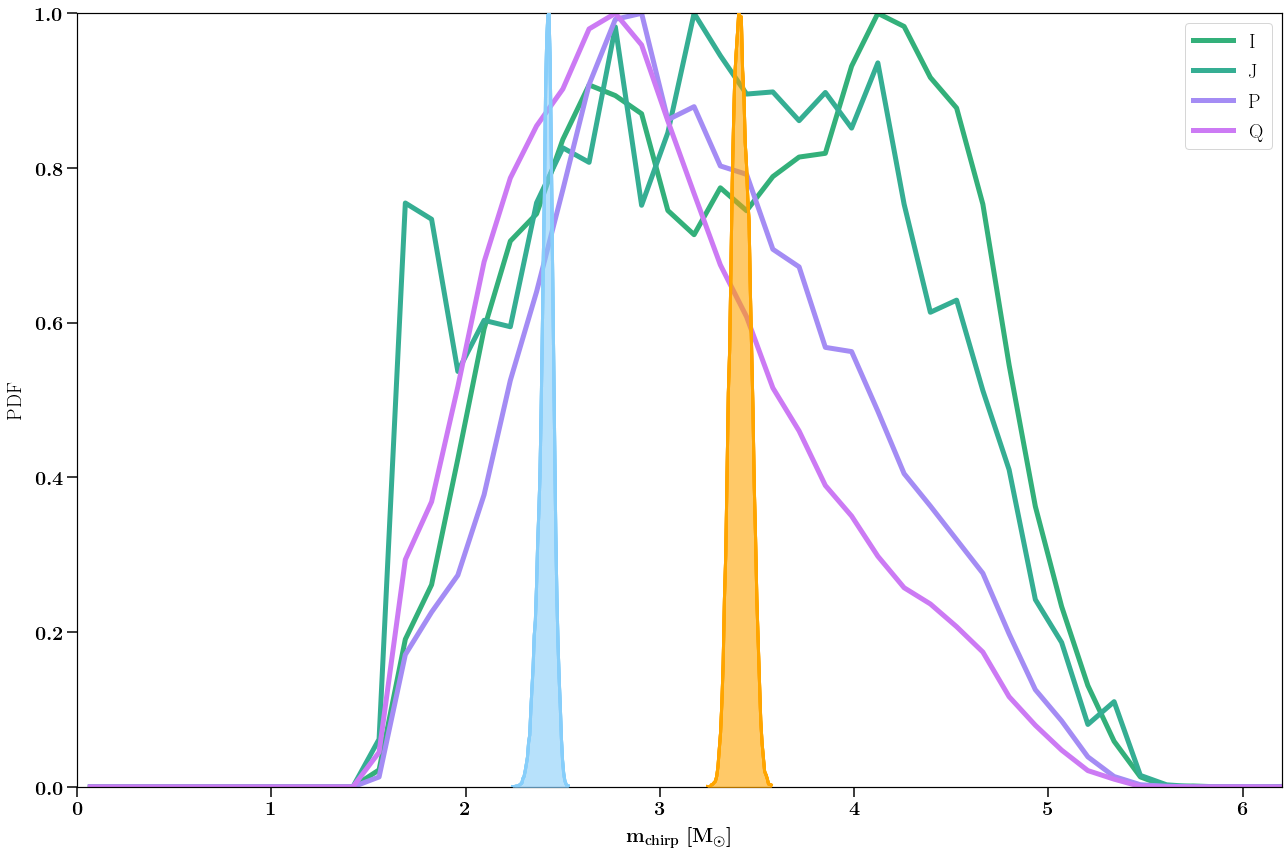

In [11]:
fs=20
def plotHist_MatchingModels(axe, BPSlist=['I', 'J', 'P', 'Q'], SFRDlist=[], jj_minn=0, jj_maxx=10):
    

    
    
    
    for ind_bps, BPSmodelName in enumerate(BPSlist):
    
        DCOtype='BHNS'
        # path for files 
        path_ = '/Volumes/Andromeda/DATA/AllDCO_bugfix/' + alphabetDirDict[BPSmodelName] +'/'
        path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

        # read in data 
        fdata = h5.File(path)
    
    
        # M1 will be the most massive, M2 the least massive compact object. 
        M1, M2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
        Chirpmass = chirpmass(M1, M2)
        MassRatio = M2/M1
        
    
    
        for ind_sfrd, mssfr in enumerate(SFRDlist[ind_bps]): 
            ### read in MSSFR weights: ###
            print('mssfr = %s'%mssfr)
            # get detected weights
            fparam_key = 'weights_detected'
            weightheader = 'w_' + mssfr
            w = fdata[fparam_key][weightheader][...].squeeze()

            labellist=[ r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{BH}} \ [\rm{M}_{\odot}]$', r'$\rm{m}_{\rm{NS}} \ [\rm{M}_{\odot}]$',\
                   r'$q $'] #,  r'$\log_{10}(t) $']              
            varlist = [Chirpmass, M1, M2, MassRatio]



            maskGW200105  = ((M1 <= (8.9+1.2))  & (M1>=(8.9-1.5))) & ((M2 <= (1.9+0.3))  & (M2>=(1.9-0.2))) & ((chirpmass(M1,M2)>=(3.41-0.07)) & (chirpmass(M1,M2)<=(3.41+0.08))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35))) & (((M2+M1)>=(10.9-1.2)) & ((M2+M1)<=(10.9+1.1)))
            maskGW200115  = ((M1 <= (5.7+1.8))  & (M1>=(5.7-2.1))) & ((M2 <= (1.5+0.7))  & (M2>=(1.5-0.3))) & ((chirpmass(M1,M2)>=(2.42-0.07)) & (chirpmass(M1,M2)<=(2.42+0.05))) & ((M2/M1>=(0.26-0.1)) & (M2/M1<=(0.26+0.35))) & (((M2+M1)>=(7.1 -1.4)) & ((M2+M1)<=(7.1 +1.5)))



            # GW lists:
            print('obtaining GW200105 and GW200115 posteriors')
            mass_1_source_GW200105, mass_2_source_GW200105, _, chirp_mass_source_GW200105, mass_ratio_GW200105, _, _ = get_GW_posteriors(GW_list=['GW200105_162426'])
            mass_1_source_GW200115, mass_2_source_GW200115, _, chirp_mass_source_GW200115, mass_ratio_GW200115, _, _ = get_GW_posteriors(GW_list=['GW200115_042309'])

            varlist_GW200115 = [chirp_mass_source_GW200115, mass_1_source_GW200115, mass_2_source_GW200115, mass_ratio_GW200115]
            varlist_GW200105 = [chirp_mass_source_GW200105, mass_1_source_GW200105, mass_2_source_GW200105, mass_ratio_GW200105]


            fs_l = 20 # label fontsize

            cGW1 = 'lightskyblue' 
            cGW0 = 'orange'
            LEGEND = True 



            jj=0

            # PLOT HISTOGRAMS
            nrbins=np.linspace(jj_minn, jj_maxx, 75)
            hist, bin_edges = np.histogram(varlist[jj], bins=nrbins, weights=w)
            yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
            xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
            axe.plot(xx, yy, color=colorDirDict[BPSmodelName], lw=5, zorder=2, label=BPSmodelName)
#             axe.fill_between(xx, y1=np.zeros_like(xx), y2=yy, color='lightgray', zorder=2, alpha=0.5)

#             hist, bin_edges = np.histogram(varlist[jj][maskGW200105], bins=nrbins, weights=w[maskGW200105])
#             yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
#             xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
#             axe.plot(xx, yy, color=cGW0, lw=3, zorder=3, ls=':')   

#             hist, bin_edges = np.histogram(varlist[jj][maskGW200115], bins=nrbins, weights=w[maskGW200115])
#             yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
#             xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
#             axe.plot(xx, yy, color=cGW1, lw=3, zorder=3, ls=':')  




            #### LVK sources ###
            nrbins = 50 

            hist, bin_edges = np.histogram( varlist_GW200105[jj], bins=nrbins)
            yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
            xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
            axe.plot(xx, yy, color=cGW0, lw=3, zorder=5)   
            axe.fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW0, zorder=4, alpha=0.2)

            hist, bin_edges = np.histogram(varlist_GW200115[jj], bins=nrbins)
            yy = hist / np.max(hist) # normalize by max to set highest bin to fixed height 1 
            xx = (bin_edges[:-1]+ bin_edges[1:])/2 # center of bins
            axe.plot(xx, yy, color=cGW1, lw=3, zorder=5)  
            axe.fill_between(xx, y1=np.zeros_like(xx), y2=yy, color=cGW1, zorder=4, alpha=0.2)
            #######################




            # BEAUTIFY: 

            ylabel='PDF'

            axe.set_xlim(jj_minn, jj_maxx)
            axe.set_ylim(0,1)
            if labellist[jj]== r'$m_{\rm{BH}} \ [M_{\odot}]$':
                axe.set_xlim(jj_minn, 27)
            if labellist[jj]==  r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$':
                axe.set_xlim(0, 6.2)
            if labellist[jj]==  r'$m_{\rm{NS}} \ [M_{\odot}]$':
                axe.set_xlim(0.9, jj_maxx)                    

            if labellist[jj]==r'$q $':
                xx = [-100, -50]
                axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightgray', zorder=2, alpha=0.5, label='All BHNS')
                axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='orange', zorder=2, alpha=0.3, label = 'GW200105')
                axe.fill_between(xx, y1=np.zeros_like(xx), y2=np.ones_like(xx), color='lightskyblue', zorder=2, alpha=0.3, label = 'GW200115')
                ax.legend(fontsize=26, loc='upper center', bbox_to_anchor=(0.65, 0.9), frameon=False)


            ax == layoutAxes(ax, nameX=labellist[jj], nameY='PDF', setMinor=False, labelpad=10, fontsize=fs_l)
    ax.legend(fontsize=fs_l)

                    
                    
                    
labellist=[r'$\rm{m}_{\rm{chirp}} \ [\rm{M}_{\odot}]$', r'$m_{\rm{BH}} \ [M_{\odot}]$', r'$m_{\rm{NS}} \ [M_{\odot}]$',\
           r'$q $'] #,  r'$\log_{10}(t) $']     

f, ax= plt.subplots(ncols=1,nrows=1,figsize=(18,12))

plotHist_MatchingModels(axe=ax, BPSlist=['I', 'J', 'P', 'Q'], SFRDlist=[['213'],['113'],['112'], ['112']], jj_minn=0, jj_maxx=10)



plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)#2)


plt.savefig('./KDE_matching_models_Mchirp'  + '.png', transparent=False, bbox_inches="tight")
plt.show()







